# Plot Training Data

In [2]:
from packaging import version

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import tensorboard as tb

import scienceplots
mpl.rc_file_defaults()
mpl.rcParams['figure.dpi'] = 300

In [3]:
print("Loading Data from Experiment")
experiment_id = "Kyh6ky7AQQyrE3REZ7jvlw"
experiment = tb.data.experimental.ExperimentFromDev(experiment_id)
all_data = experiment.get_scalars()

# df = df[df["run"].str.contains("PPO")]
df = all_data[~all_data["run"].str.contains("DDPG|TD3")]

# Select only the rows where the "tag" column has the values "rollout/ep_len_mean" or "rollout/ep_rew_mean"
df = df[df['tag'].isin(['rollout/ep_len_mean', 'rollout/ep_rew_mean'])]
df = tb.data.experimental.utils.pivot_dataframe(df)

# Rename the columns to "ep_len_mean" and "ep_rew_mean"
df = df.rename(columns={'rollout/ep_len_mean': 'ep_len_mean', 'rollout/ep_rew_mean': 'ep_rew_mean'})

print(f"The following runs will be processed: \n"
      f"{df['run'].unique()}")

Loading Data from Experiment
The following runs will be processed: 
['random_test,run_1_0' 'random_test,run_2_0' 'random_test,run_3_0'
 'random_test,run_4_0' 'random_test,run_5_0']


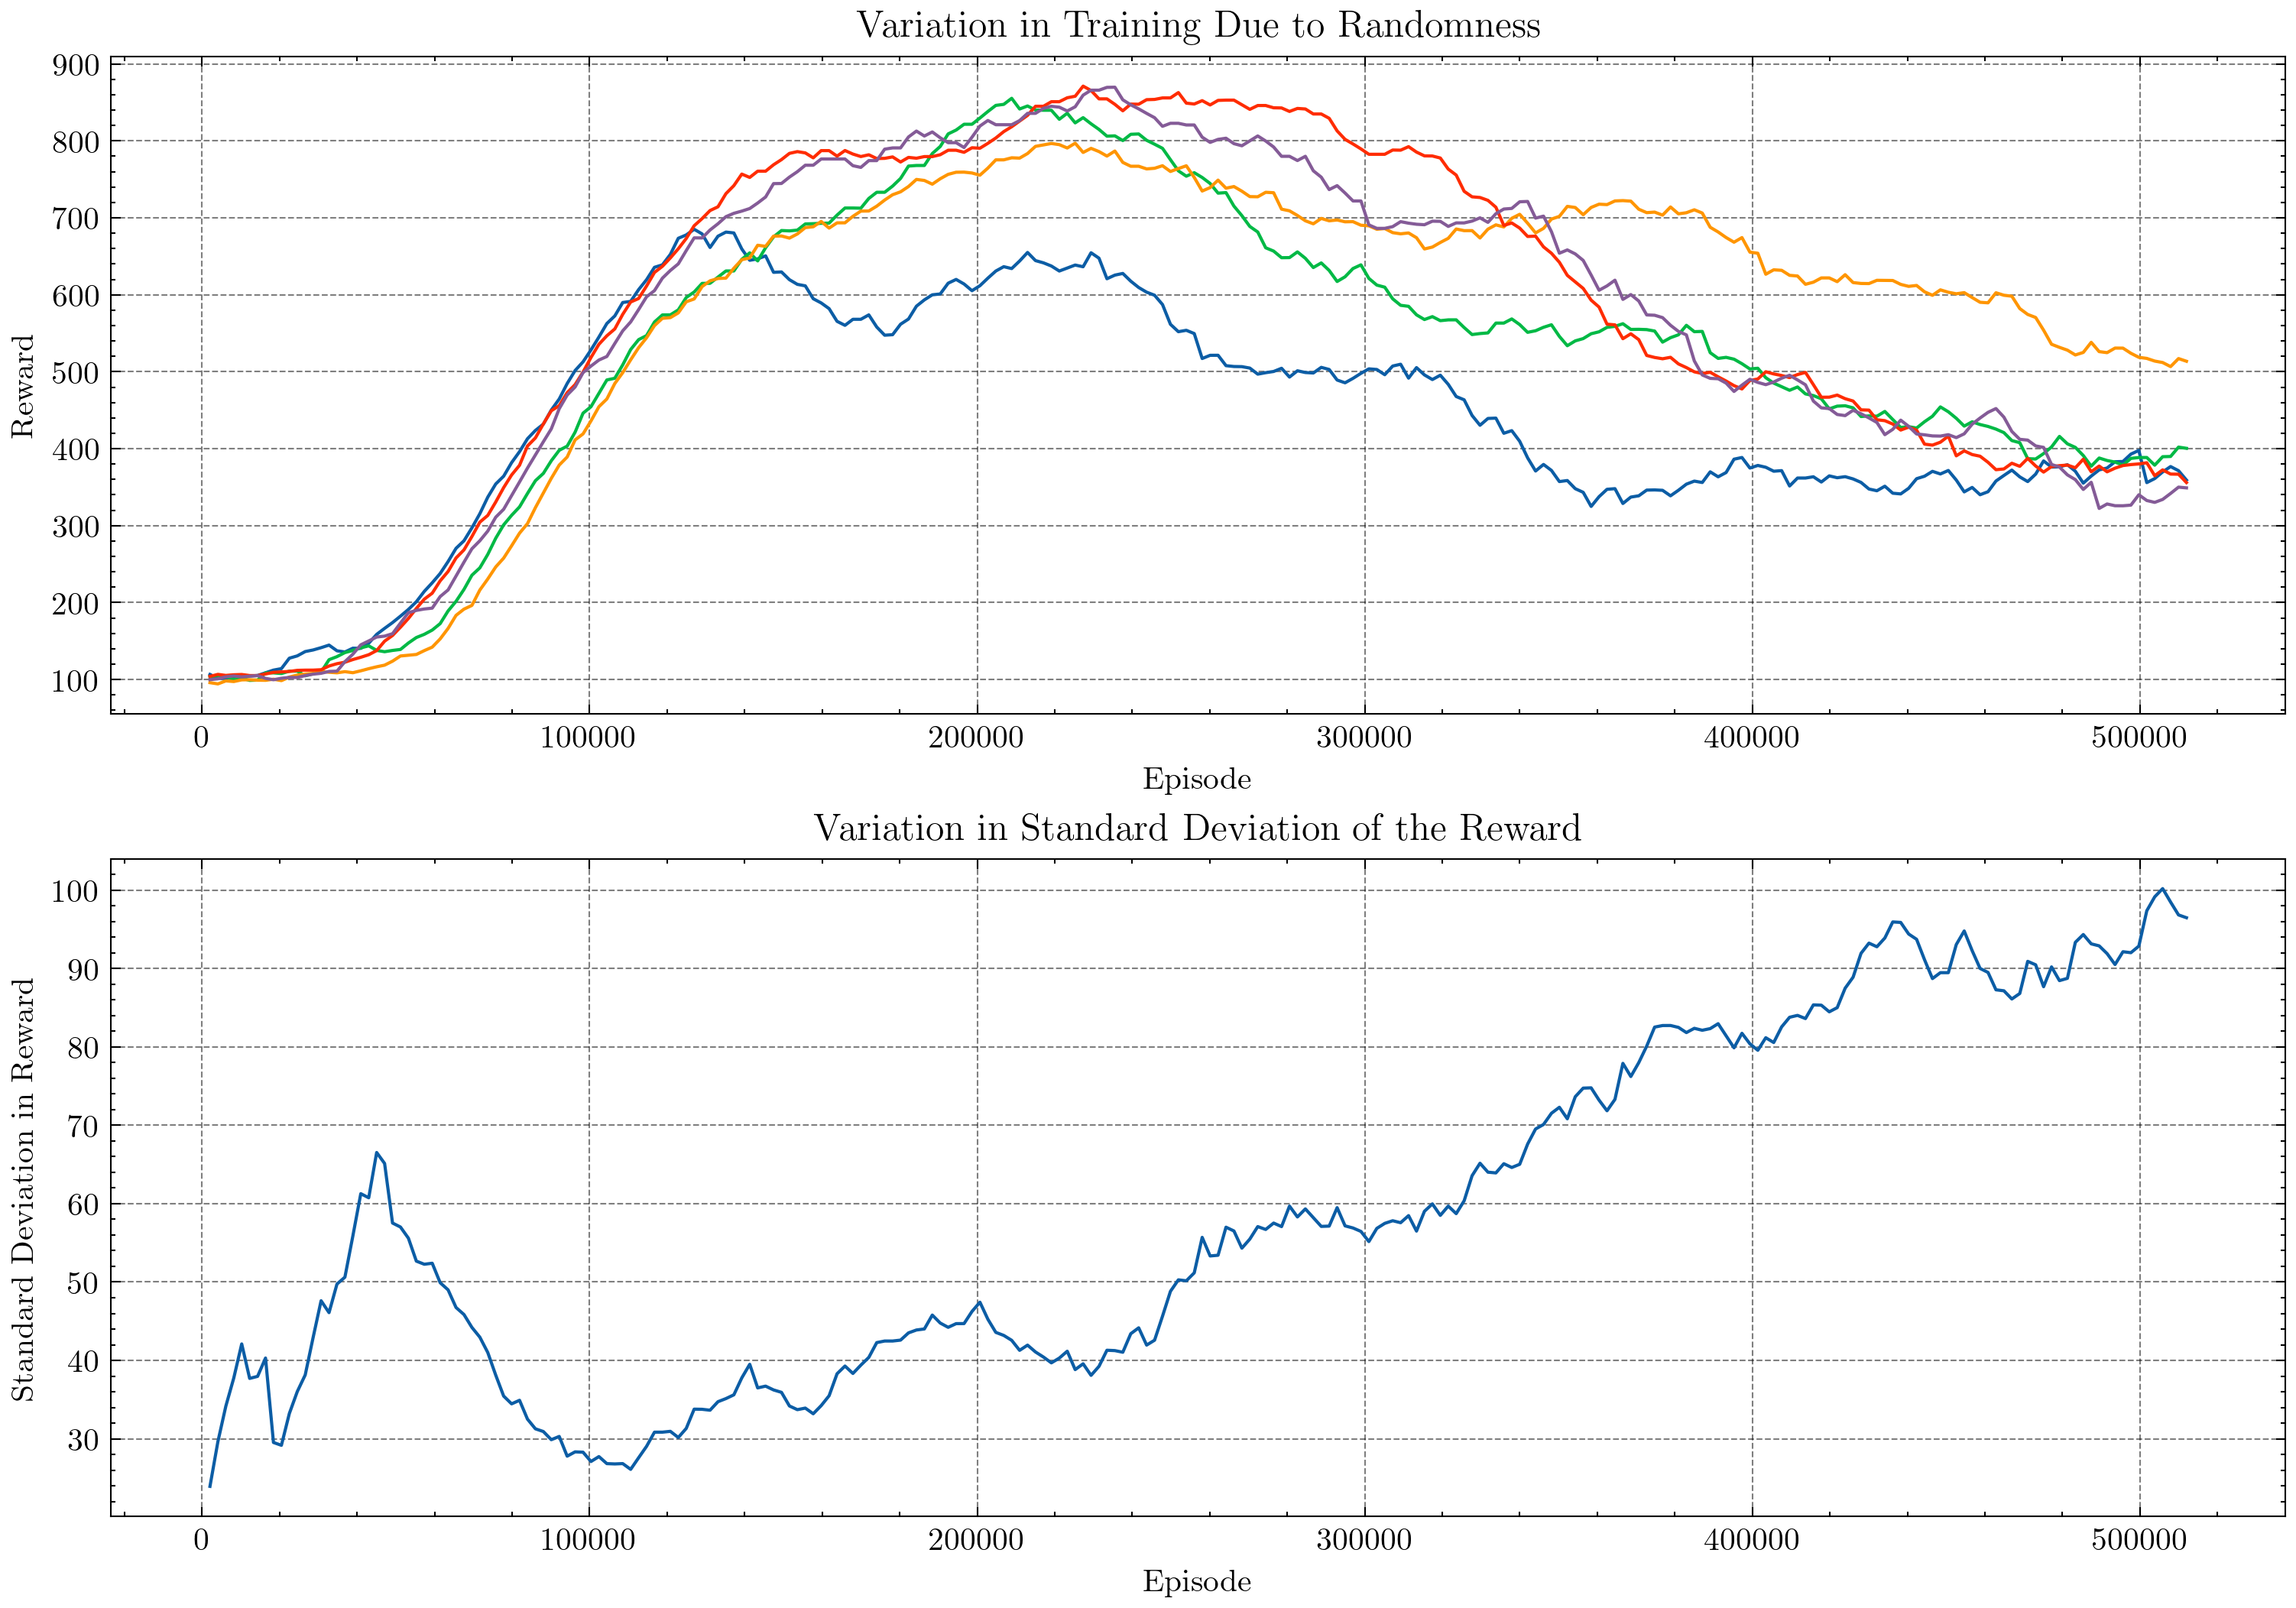

In [6]:
plt.style.use(['science', 'grid'])
plt.rcParams['figure.figsize'] = [10, 7]


# Group the data by the "step" column and compute the mean and standard deviation of the "ep_len_mean" column for each group
grouped_df = df.groupby('step')['ep_rew_mean'].agg(['mean', 'std'])

# Reset the index to make "step" a regular column
grouped_df = grouped_df.reset_index()

# Extract the mean and standard deviation values as NumPy arrays
mean_values = grouped_df['mean'].values
std_values = grouped_df['std'].values

fig, ax = plt.subplots(2, 1, layout="constrained")

for i in range(1, 5+1):
    curr_df = df[df["run"].str.contains(str(i))]
    ax[0].plot(curr_df["step"], curr_df["ep_len_mean"])


# Set the title and axis labels
ax[0].set_title("Variation in Training Due to Randomness")
ax[0].set_xlabel("Episode")
ax[0].set_ylabel("Reward")

ax[1].plot(grouped_df['step'], std_values)

# Set the title and axis labels
ax[1].set_title("Variation in Standard Deviation of the Reward")
ax[1].set_xlabel("Episode")
ax[1].set_ylabel("Standard Deviation in Reward")

plt.savefig('images/randomnessTest.png', dpi=300)

plt.show()
plt.style.use(['science', 'grid', 'high-vis'])

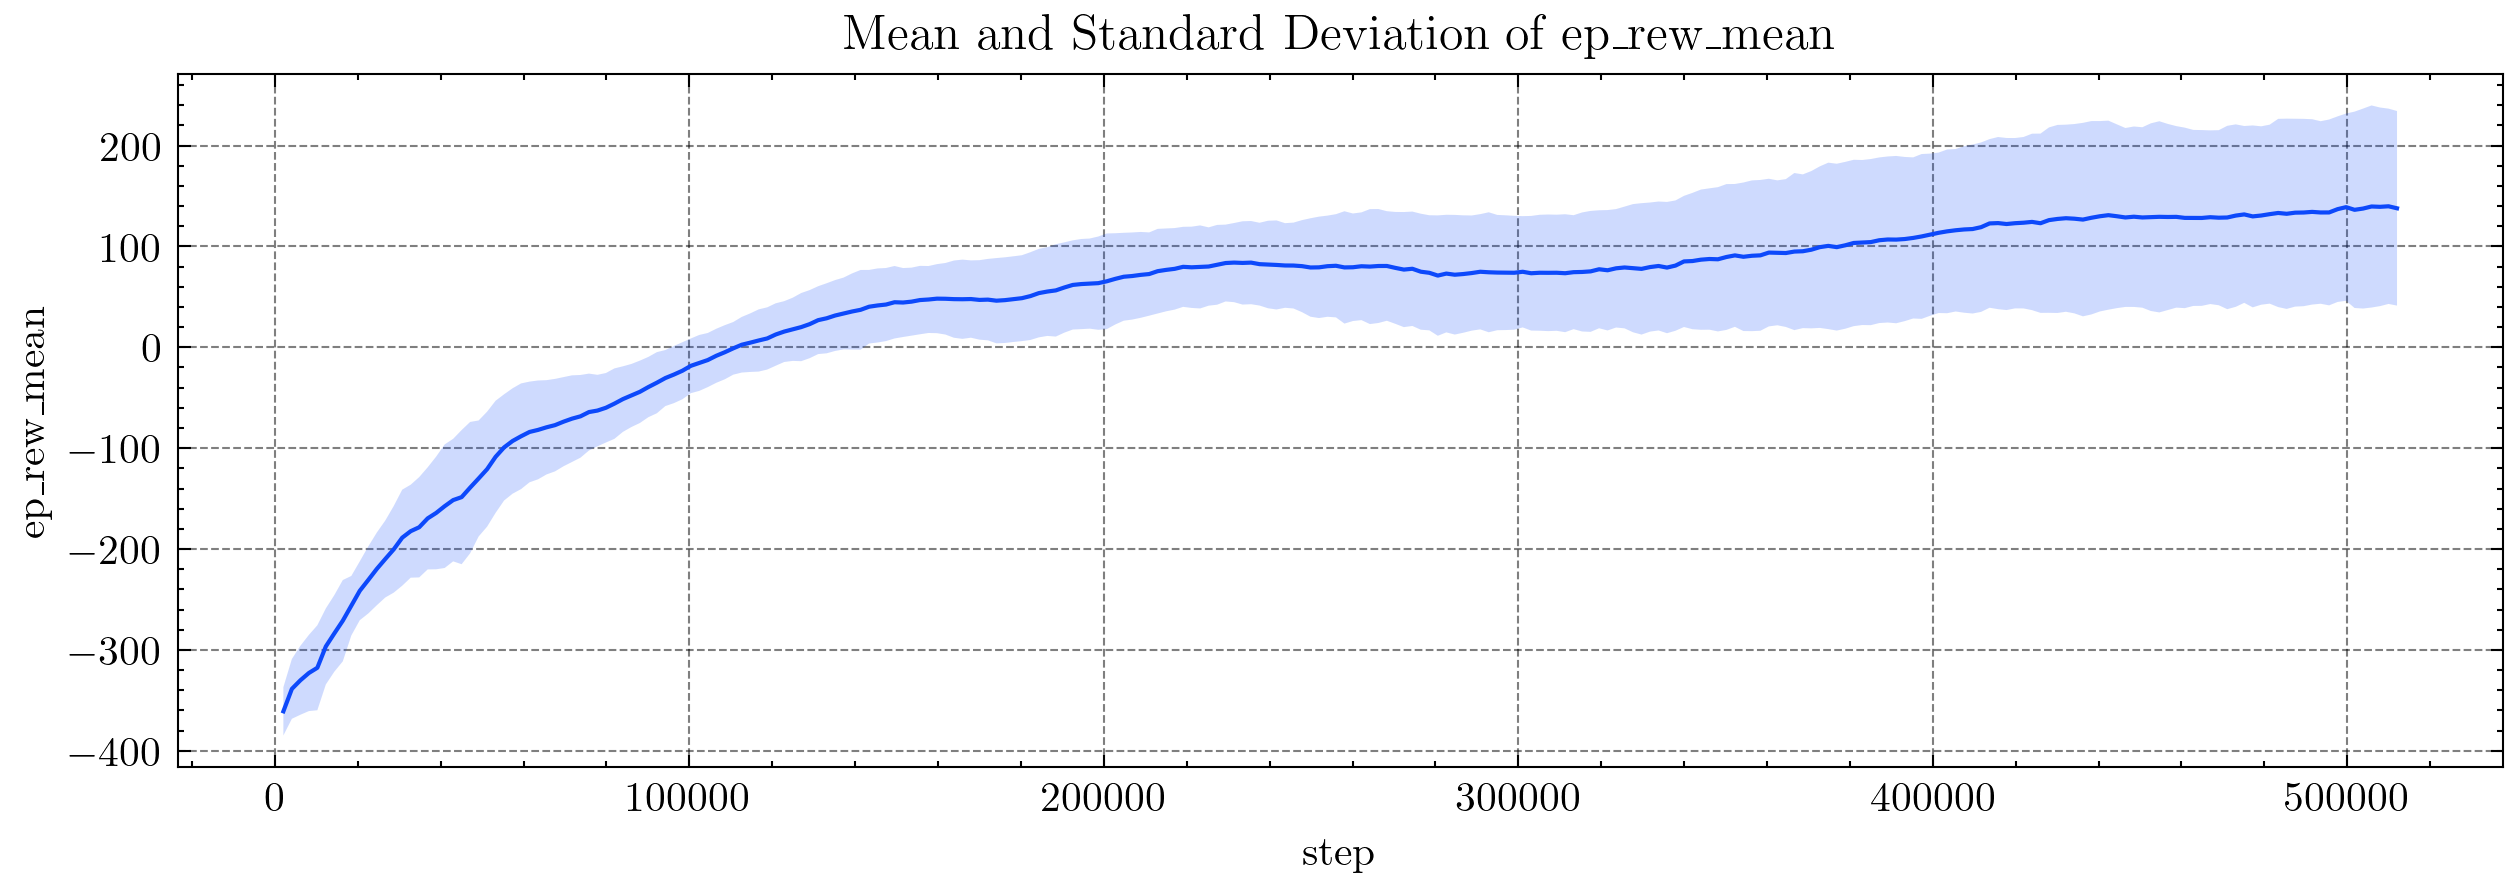

In [87]:
plt.style.use(['science', 'grid', 'high-vis'])

# Group the data by the "step" column and compute the mean and standard deviation of the "ep_len_mean" column for each group
grouped_df = df.groupby('step')['ep_rew_mean'].agg(['mean', 'std'])

# Reset the index to make "step" a regular column
grouped_df = grouped_df.reset_index()

# Extract the mean and standard deviation values as NumPy arrays
mean_values = grouped_df['mean'].values
std_values = grouped_df['std'].values

# Create a Matplotlib figure and axis object
plt.rcParams['figure.figsize'] = [10, 3]
fig, ax = plt.subplots()

# Plot the mean value of the "ep_len_mean" column
ax.plot(grouped_df['step'], mean_values)

# Shade the region +/- one standard deviation away from the mean
ax.fill_between(grouped_df['step'], mean_values - std_values, mean_values + std_values, alpha=0.2)

# Set the title and axis labels
ax.set_title("Mean and Standard Deviation of ep_rew_mean")
ax.set_xlabel("step")
ax.set_ylabel("ep_rew_mean")

plt.show()

---
## Algorithm Comparison

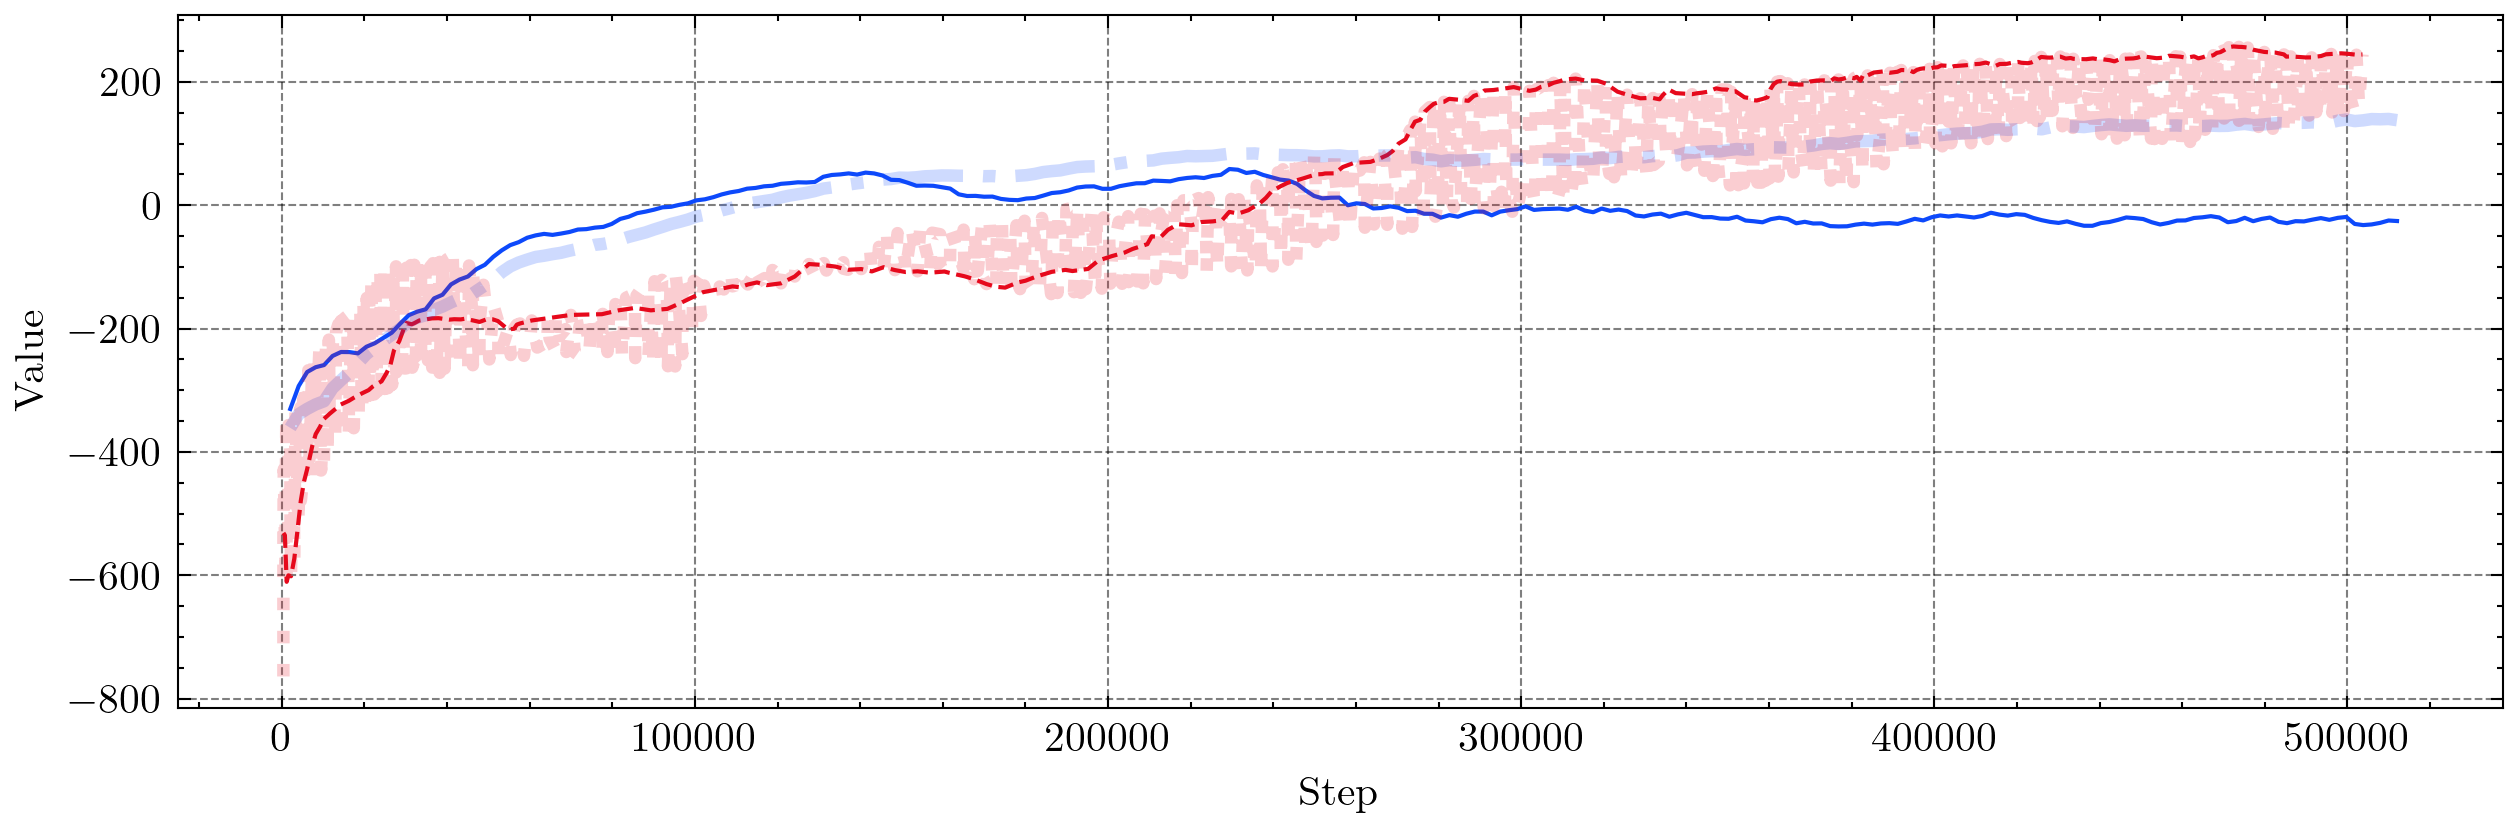

In [100]:
plt.style.use(['science', 'grid', 'high-vis'])
plt.rcParams['figure.figsize'] = [10, 3]

# df = df[df["run"].str.contains("PPO")]
ac_df = all_data[all_data['tag'].isin(['rollout/ep_rew_mean'])]

ac_ddpg = ac_df[ac_df["run"].str.contains("DDPG")]
ac_ddpg_run1 = ac_ddpg[ac_ddpg["run"].str.contains("1")]

ac_ppo = ac_df[~ac_df["run"].str.contains("DDPG|TD3")]
ac_ppo_run1 = ac_ppo[ac_ppo["run"].str.contains("1")]

# Group the data by the "tag" and "step" columns and calculate the mean and standard deviation of each group
grouped_ddpg = ac_ddpg.groupby(["tag", "step"])
means_ddpg = grouped_ddpg["value"].mean().unstack(level=0)

grouped_ppo = ac_ppo.groupby(["tag", "step"])
means_ppo = grouped_ppo["value"].mean().unstack(level=0)

# Plot the means and standard deviations as a line plot with shaded region
fig, ax = plt.subplots()

l1 = ax.plot(ac_ppo_run1["step"], ac_ppo_run1["value"])
l2 = ax.plot(ac_ddpg_run1["step"], ac_ddpg_run1["value"])
ax.plot(means_ppo.index, means_ppo["rollout/ep_rew_mean"], alpha=0.2, color=l1[0].get_color(), linewidth=3)
ax.plot(means_ddpg.index, means_ddpg["rollout/ep_rew_mean"], alpha=0.2, color=l2[0].get_color(), linewidth=3)
# ax.legend()
ax.set_xlabel("Step")
ax.set_ylabel("Value")
plt.show()

-352.63427734375
-531.3563842773438
-610.73388671875


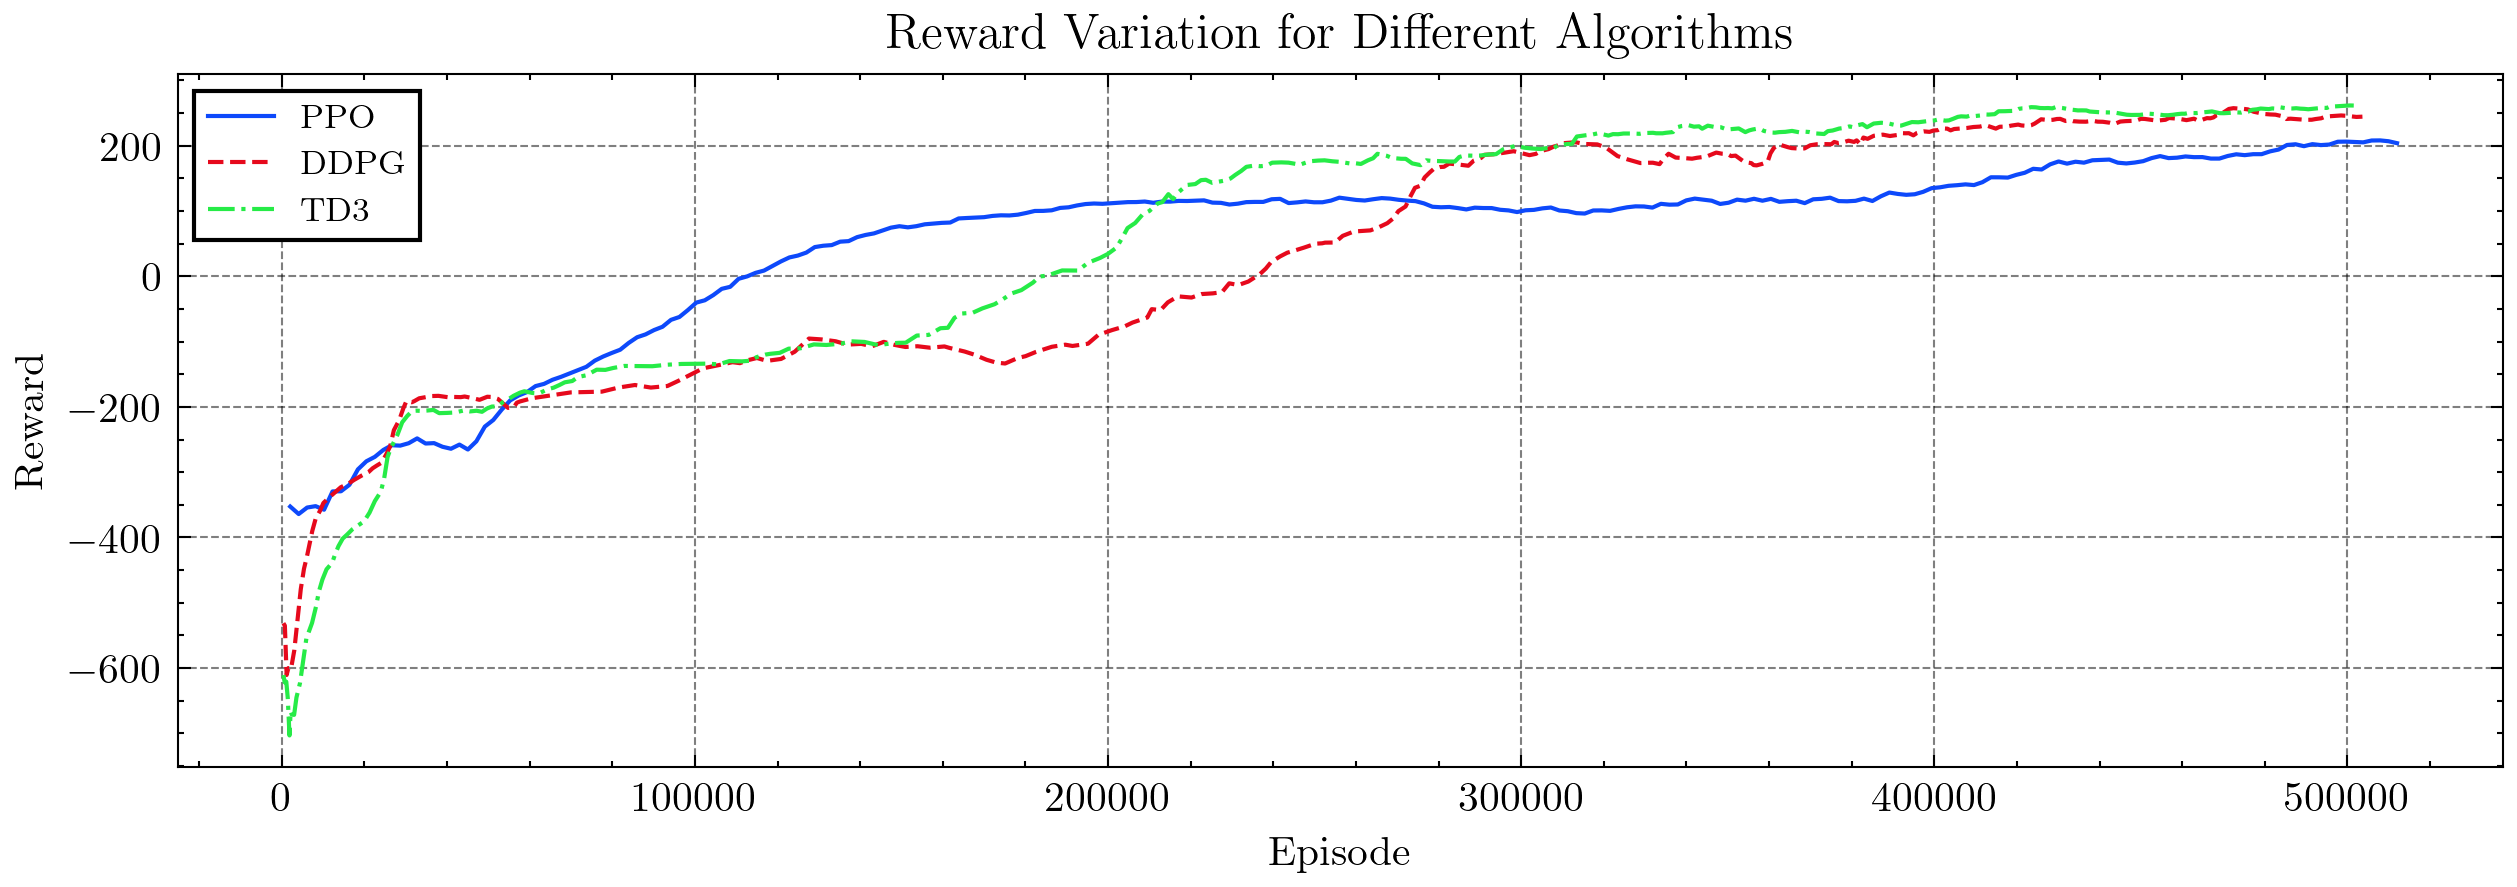

In [7]:
plt.style.use(['science', 'grid', 'high-vis'])
plt.rcParams['figure.figsize'] = [10, 3]

# df = df[df["run"].str.contains("PPO")]
ac_df = all_data[all_data['tag'].isin(['rollout/ep_rew_mean'])]

# Define the colors and labels for each group of runs
colors = {"PPO": "blue", "DDPG": "red", "TD3": "green"}
labels = {"PPO": "PPO runs", "DDPG": "DDPG runs", "TD3": "TD3 runs"}
regexs = [r"^(?!.*DDPG)(?!.*TD3).*$", "DDPG", "TD3"]

# Loop over the algorithms and plot the ep_rew_mean against step
for i, alg in enumerate(["PPO", "DDPG", "TD3"]):
    # Filter the data by the current algorithm
    data = ac_df[ac_df["run"].str.contains(regexs[i], regex=True)]

    # Get the unique run IDs for the current algorithm
    runs = data["run"].unique()

    # Set the color and label for the current algorithm
    color = colors[alg]
    label = labels[alg]


    plotted = 0
    # Loop over the runs and plot the data
    for i, run in enumerate(runs):

        if alg == "PPO" and i == 0:
            continue
        # Filter the data by the current run
        run_data = data[data["run"] == run]

        # Plot the ep_rew_mean against step
        plt.plot(run_data["step"], run_data["value"], label=alg)

        print(run_data["value"].iloc[0])

        plotted += 1

        if plotted == 1:
            break

    # Add a label to the plot
    # plt.plot([], [], color=color,)

# Add a legend and axis labels
plt.legend(fontsize=8, fancybox=False, edgecolor='black')
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Reward Variation for Different Algorithms")

plt.savefig('images/algorithmComparisonReward.png', dpi=300)

# Show the plot
plt.show()

In [135]:
a= 203.8240509033203
b= 244.4160919189453
c= 261.45648193359375

d = ((b+c)/2)

print(((a - d) / (d+352)) *100)

-8.11857993715214


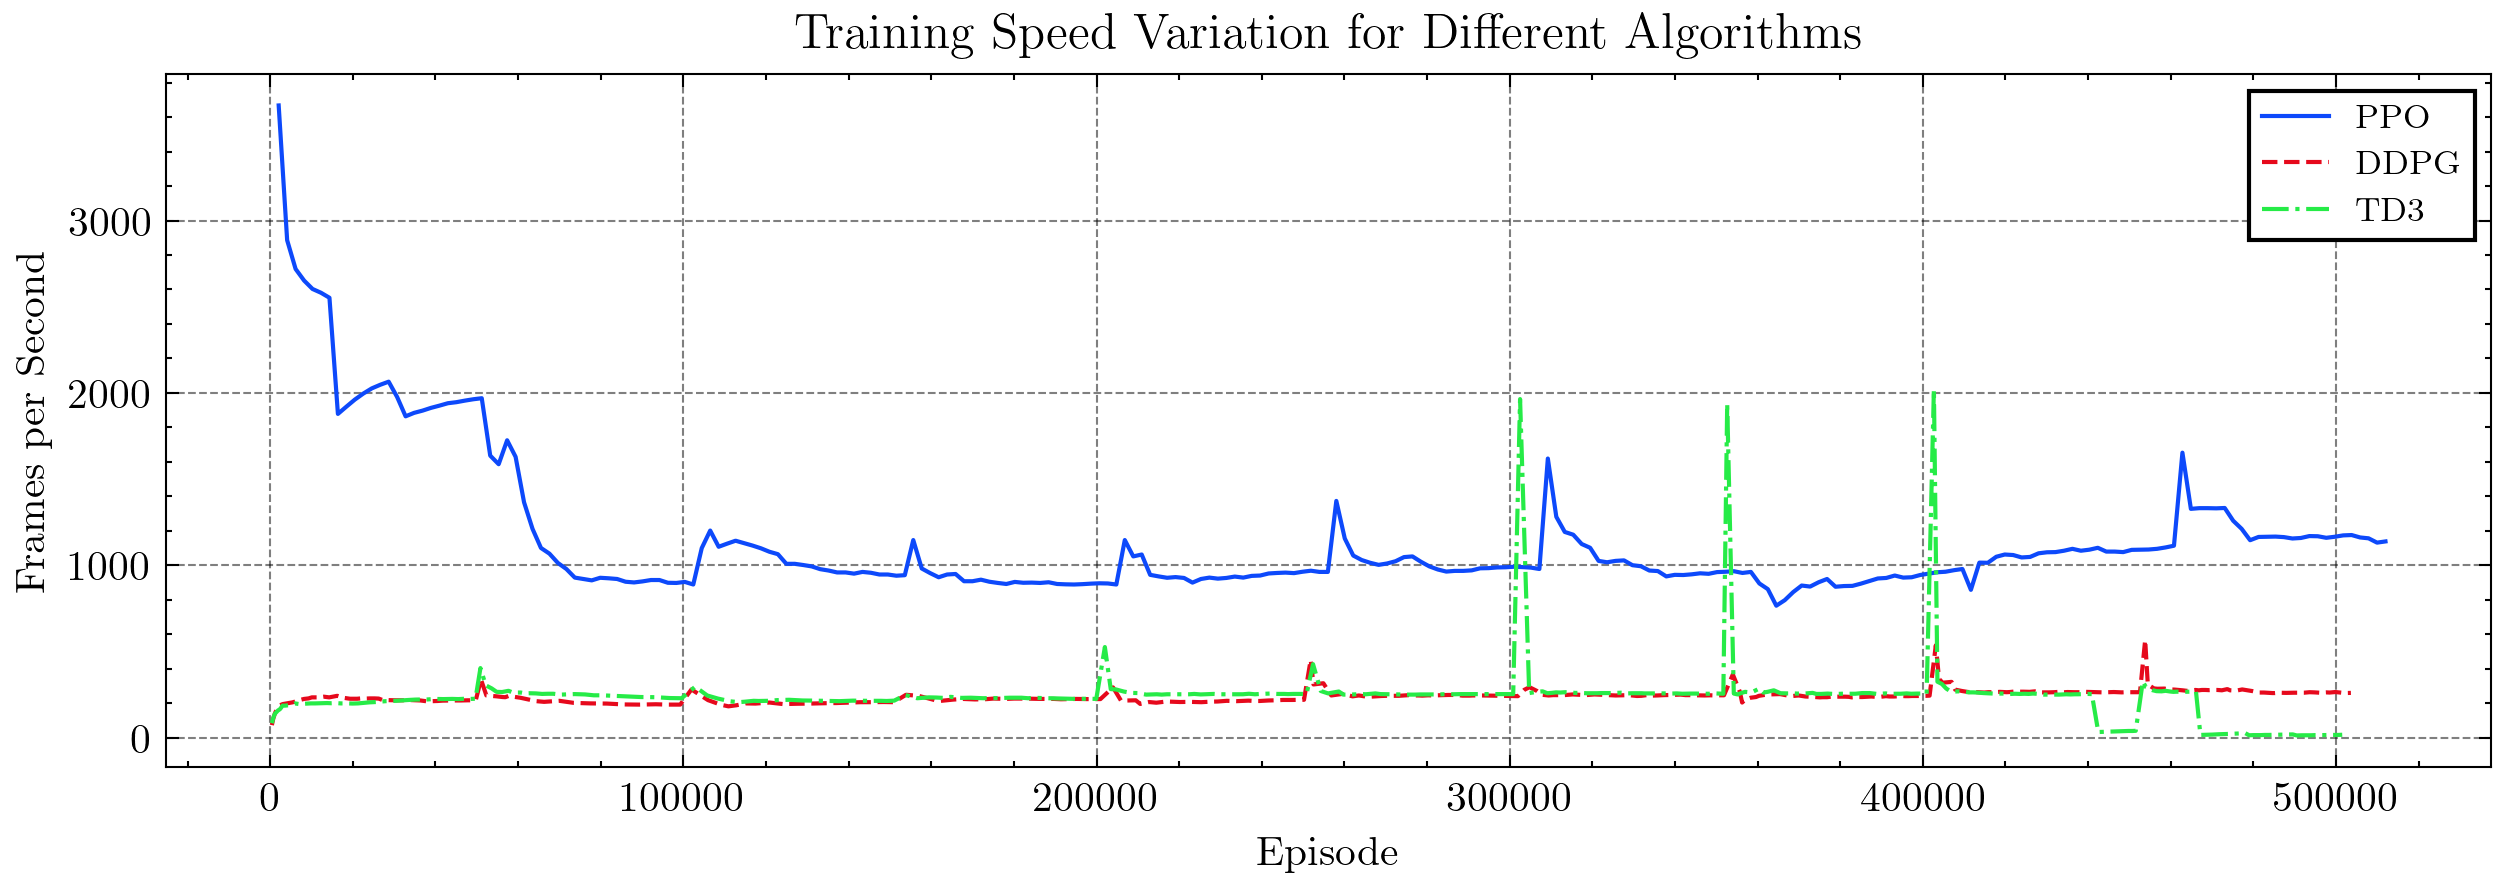

In [8]:
plt.style.use(['science', 'grid', 'high-vis'])
plt.rcParams['figure.figsize'] = [10, 3]

# df = df[df["run"].str.contains("PPO")]
ac_df = all_data[all_data['tag'].isin(['time/fps'])]

# Define the colors and labels for each group of runs
colors = {"PPO": "blue", "DDPG": "red", "TD3": "green"}
labels = {"PPO": "PPO runs", "DDPG": "DDPG runs", "TD3": "TD3 runs"}
regexs = [r"^(?!.*DDPG)(?!.*TD3).*$", "DDPG", "TD3"]

# Loop over the algorithms and plot the ep_rew_mean against step
for i, alg in enumerate(["PPO", "DDPG", "TD3"]):
    # Filter the data by the current algorithm
    data = ac_df[ac_df["run"].str.contains(regexs[i], regex=True)]

    # Get the unique run IDs for the current algorithm
    runs = data["run"].unique()

    # Set the color and label for the current algorithm
    color = colors[alg]
    label = labels[alg]


    plotted = 0
    # Loop over the runs and plot the data
    for i, run in enumerate(runs):

        if alg == "PPO" and i == 0:
            continue
        # Filter the data by the current run
        run_data = data[data["run"] == run]

        # Plot the ep_rew_mean against step
        plt.plot(run_data["step"], run_data["value"], label=alg)
        plotted += 1

        if plotted == 1:
            break

    # Add a label to the plot
    # plt.plot([], [], color=color,)

# Add a legend and axis labels
plt.xlabel("Episode")
plt.ylabel("Frames per Second")
plt.title("Training Speed Variation for Different Algorithms")
plt.legend(fontsize=8, fancybox=False, edgecolor='black')

plt.savefig('images/algorithmComparisonTrainingSpeed.png', dpi=300)
# Show the plot
plt.show()